In [1]:
%load_ext autoreload
%autoreload 2

## Possible Applications of the probing stuff

* Apply the probes across some free-form text. See if they respond to the semantic information of something like "Fruit". The probe direction would be $q_{\text{fruit}} @ \text{W}_k^T$
    * What could be a setup where the ground truth isn't obvious? Or, hard to get? Checkout Martin's modeling of users setup?

* If we cluster the query states based on cosine similarity, do we see any patterns? Maybe some of the heads are doing more of semantic stuff, while other are doing something to do with task / formatting?

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-21 13:31:02 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-21 13:31:02 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=7, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-21 13:31:02 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-21 13:31:05 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-21 13:31:05 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-21 13:31:05 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-21 13:31:05 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-21 13:31:06 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-21 13:31:06 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-21 13:31:06 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-21 13:31:06 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-21 13:31:06 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-21 13:31:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-21 13:31:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-21 13:31:57 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 2
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



2025-09-21 13:31:58 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data


2025-09-21 13:31:58 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-09-21 13:31:58 matplotlib DEBUG    interactive is False
2025-09-21 13:31:58 matplotlib DEBUG    platform is linux
2025-09-21 13:31:58 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-09-21 13:31:58 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-09-21 13:31:58 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-21 13:31:58 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-09-21 13:31:58 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-09-21 13:31:58 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/S

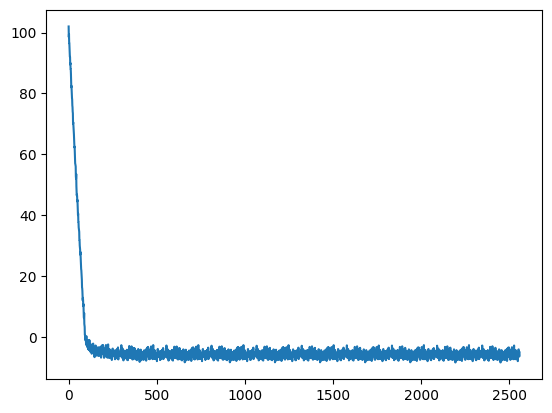

In [6]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     model_key.split("/")[-1],
#     # "distinct_options",
#     f"{select_task.task_name}",
#     "epoch_10.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)



optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


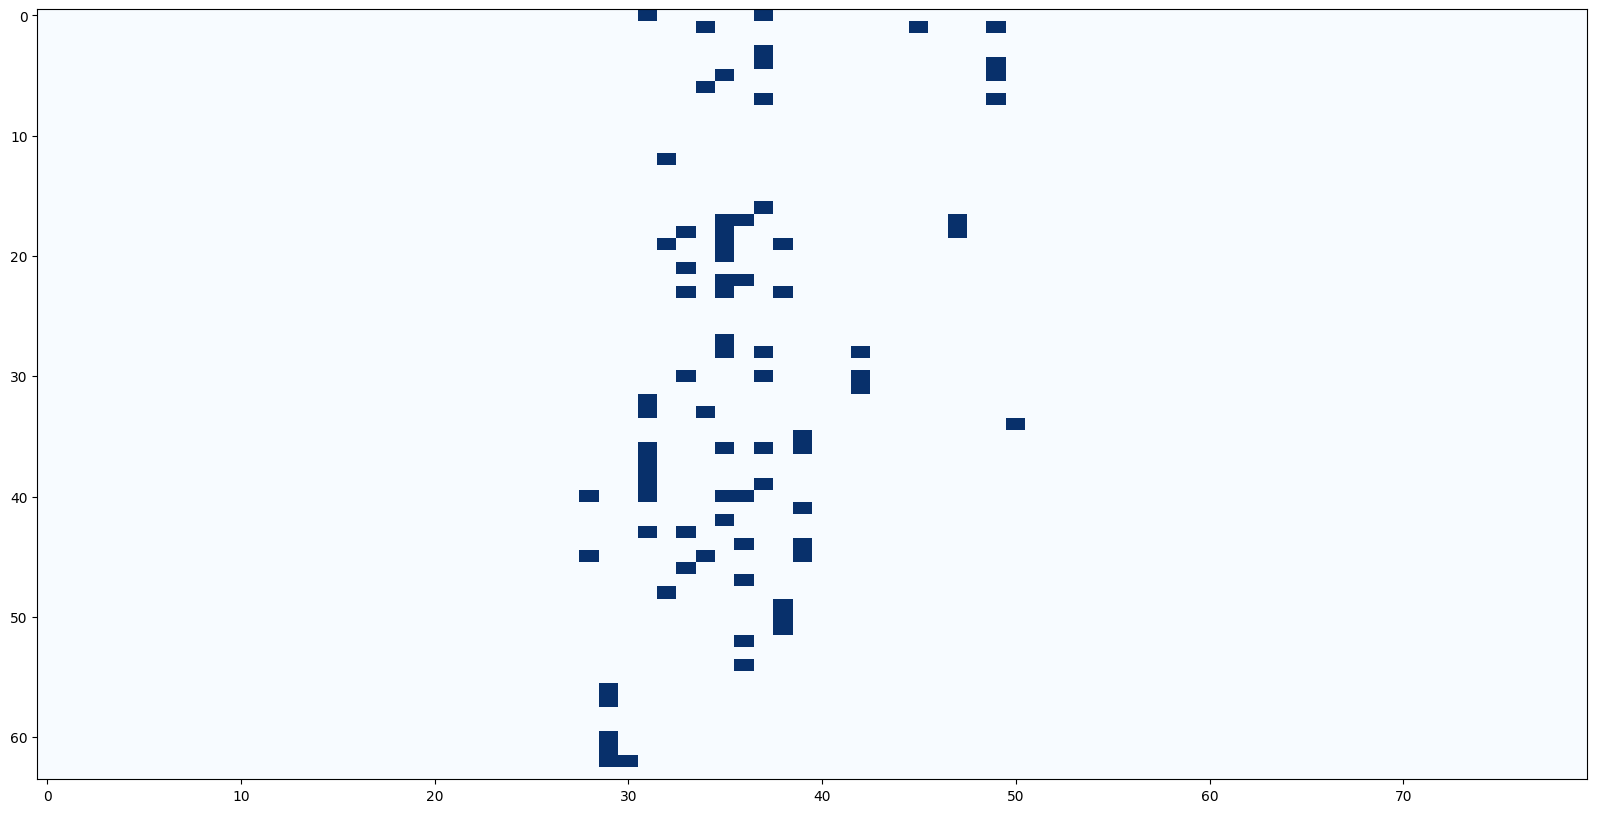

In [7]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected
]
print(len(heads_selected))

# HEADS = heads_selected

# (35, 19) in HEADS, (35, 19) in heads_selected

## Probe without any training

In [8]:
from tqdm.auto import tqdm
from src.selection.functional import cache_q_projections
from src.tokens import prepare_input, find_token_range
from src.utils.typing import TokenizerOutput

###########################################
limit = 10
prompt_template_idx=3
option_style="single_line"
###########################################

def get_probe_directions():
    logger.info("Getting the samples for caching the predicate")
    category_wise_samples = {}
    for category in tqdm(select_task.categories):
        category_wise_samples[category] = []
        for idx in range(limit):
            sample = select_task.get_random_sample(
                mt=mt,
                category=category,
                prompt_template_idx=prompt_template_idx,
                option_style=option_style,
                n_distractors=N_DISTRACTORS,
                filter_by_lm_prediction=True
            )
            category_wise_samples[category].append(sample)

    logger.info("Caching the predicate directions")
    category_wise_q_states = {category: None for category in select_task.categories}
    for category in select_task.categories:
        prompts = [sample.prompt() for sample in category_wise_samples[category]]
        tokenized_prompts = prepare_input(
            prompts=prompts,
            tokenizer=mt.tokenizer,
        )
        category_wise_q_states[category] = cache_q_projections(
            mt=mt,
            input=tokenized_prompts,
            heads=heads_selected,
            token_indices=[[-3, -2, -1] for _ in range(len(prompts))],
            projection_signature=".q_proj"
        )
    
    logger.info("Computing the mean")
    category_wise_q_mean = {category: {} for category in select_task.categories}
    for category in select_task.categories:
        keys = list(category_wise_q_states[category][0].keys())
        for key in keys:
            q_states = torch.stack(
                [sample_states[key] for sample_states in category_wise_q_states[category]]
            )
            category_wise_q_mean[category][key] = q_states.mean(dim=0)
            # print(category, key, q_states.shape,category_wise_q_mean[category][key].shape)

    return category_wise_q_mean

In [9]:
category_wise_q_mean = get_probe_directions()
category_wise_q_mean["fruit"][(35, 19, -1)].shape

2025-09-21 13:31:59 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:32:18 src.selection.data ERROR    Sample = Television -> Camera (1): ['Raspberry', 'Camera', 'Rabbit', 'Marigold', 'Brooch', 'Coffee table']
    Top prediction (1, PredictedToken(token=' Raspberry', prob=0.62109375, logit=20.375, token_id=48665, metadata=None)) does not match the object Camera[14669, " Camera"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:32:20 src.selection.data ERROR    Sample = Football -> Bat (4): ['Air fryer', 'Church', 'Spinach', 'Eucalyptus', 'Bat', 'Ruler']
    Top prediction (2, PredictedToken(token=' R', prob=0.1923828125, logit=19.25, token_id=432, metadata=None)) does not match the object Bat[16488, " Bat"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:32:32 src.selection.data ERROR    Sample = Bathtub -> Shampoo (2): ['Warehouse', 'Dishwasher', 'Shampoo', 'Necklace', 'Shirt', 'Smartwatch']
    Top prediction (1, PredictedToken(token=' Dish', prob=0.400390625, logit=20.375, token_id=49268, metadata=None)) does not match the obje

torch.Size([128])

In [10]:
from src.functional import PatchSpec
patches_per_category = {category: [] for category in select_task.categories}
for category in select_task.categories:
    patches = []
    for (layer_idx, head_idx, query_idx), q_proj in category_wise_q_mean[category].items():
        patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_idx
                ),
                patch=q_proj
            )
        )
    patches_per_category[category] = patches

In [11]:
import random
from src.selection.functional import verify_head_patterns

category="fruit"
test_sample = select_task.get_random_sample(
    mt=mt,
    category=random.choice(list(set(select_task.categories) - {category})),
    prompt_template_idx=prompt_template_idx,
    option_style=option_style,
    n_distractors=N_DISTRACTORS,
    filter_by_lm_prediction=True,
    obj_idx=4,
    insert_distractor=[("Apple", 2)]
)
print(test_sample.prompt())

Options: Shower, Notebook, Apple, Banana, Bench, Cello.
Which among these objects mentioned above is a furniture?
Answer:


In [12]:
clean_run = verify_head_patterns(
    prompt=test_sample.prompt(),
    mt=mt,
    # heads=[(35, 19)],
    heads=heads_selected,
)

2025-09-21 13:32:47 src.selection.functional DEBUG    Predictions: ['" Bench"[36358] (p=0.711, logit=21.625)', '" The"[578] (p=0.109, logit=19.750)', '" A"[362] (p=0.066, logit=19.250)', '" Among"[22395] (p=0.066, logit=19.250)', '" B"[426] (p=0.005, logit=16.750)']
2025-09-21 13:32:47 src.selection.functional INFO     Combined attention matrix for all heads


In [13]:
patched_run = verify_head_patterns(
    prompt=test_sample.prompt(),
    mt=mt,
    # heads=[(35, 19)],
    heads=heads_selected,
    query_patches=patches_per_category[category]
)

2025-09-21 13:32:48 src.selection.functional DEBUG    Predictions: ['" Apple"[8325] (p=0.793, logit=21.500)', '" Banana"[76924] (p=0.074, logit=19.125)', '" The"[578] (p=0.040, logit=18.500)', '" Among"[22395] (p=0.024, logit=18.000)', '" An"[1556] (p=0.016, logit=17.625)']
2025-09-21 13:32:48 src.selection.functional INFO     Combined attention matrix for all heads


In [14]:
from typing import Literal

def apply_probe_in_place(
    obj: str,
    mt: ModelandTokenizer,
    heads: list[tuple[int, int]],
    category_wise_probes: dict[tuple[int, int, int], torch.Tensor],
    prompt_template:str = "Option: {}",
    metric: Literal["cosine", "dot"] = "dot",
):
    probe_prompt = prompt_template.format(obj)
    probe_tokenized = prepare_input(
        prompts=[probe_prompt],
        tokenizer=mt.tokenizer,
    )
    key_states = cache_q_projections(
        mt=mt,
        input=probe_tokenized,
        heads=heads,
        token_indices=[[-1]],
        projection_signature=".k_proj"
    )
    category_wise_scores = {category: [] for category in category_wise_probes.keys()}
    for layer_idx, head_idx in heads:
        key_state = key_states[0][(layer_idx, head_idx, -1)]  # (d_head,)
        for category in category_wise_probes.keys():
            probe = category_wise_probes[category][(layer_idx, head_idx, -1)]
            if metric == "dot":
                score = torch.dot(key_state, probe).item()
            elif metric == "cosine":
                score = torch.nn.functional.cosine_similarity(key_state, probe, dim=0).item()
            else:
                raise ValueError(f"Unsupported metric: {metric}")

            category_wise_scores[category].append(score)
    category_wise_scores = {
        category: sum(scores) / len(scores)
        for category, scores in category_wise_scores.items()
    }
    prediction = sorted(
        category_wise_scores.items(),
        key=lambda x: x[1],
        reverse=True
    )
    return prediction[0][0], prediction


obj = "airplane"
# obj = incorrect_predictions[3][0]
print(f"Object: {obj}")
apply_probe_in_place(
    obj=obj,
    mt=mt,
    heads=[(35, 19)],
    # heads=heads_selected,
    category_wise_probes=category_wise_q_mean,
    # prompt_template="Option: {}",
    prompt_template="""
Apple -> fruit
Eagle -> bird
{}""",
    metric="cosine",
)

Object: airplane


('vehicle',
 [('vehicle', 0.1943359375),
  ('electronics', 0.10009765625),
  ('sport equipment', 0.0634765625),
  ('furniture', 0.03662109375),
  ('building', 0.0263671875),
  ('kitchen appliance', 0.01806640625),
  ('music instrument', 0.00946044921875),
  ('animal', 0.0024566650390625),
  ('clothing', -0.03271484375),
  ('tree', -0.047119140625),
  ('bathroom item', -0.080078125),
  ('office supply', -0.08935546875),
  ('fruit', -0.10498046875),
  ('jewelry', -0.1162109375),
  ('vegetable', -0.12060546875),
  ('flower', -0.1806640625)])

### In-place probe accuracy

In [37]:
len(select_task.categories)

16

In [15]:
objects = []
for category in select_task.categories:
    objects.extend([(obj, category) for obj in select_task.category_wise_examples[category]])

In [16]:
correct_predictions = []
incorrect_predictions = []

prompt_template = """
Apple -> fruit
Eagle -> bird
{}"""

# prompt_template = "We know that {}" 

for obj, category in tqdm(objects):
    prediction, scores = apply_probe_in_place(
        obj=obj,
        mt=mt,
        heads=[(35, 19)],
        # heads=heads_selected,
        category_wise_probes=category_wise_q_mean,
        prompt_template=prompt_template,
        metric="cosine",
    )
    if prediction == category:
        correct_predictions.append((obj, category, scores))
    else:
        incorrect_predictions.append((obj, category, prediction, scores))

accuracy = len(correct_predictions) / len(objects)
print(f"Accuracy: {accuracy*100:.2f}% ({len(correct_predictions)}/{len(objects)})")

  0%|          | 0/238 [00:00<?, ?it/s]

Accuracy: 81.93% (195/238)


In [17]:
N_TRIALS = 10
TRIAL_RESULTS = []
for trial in range(N_TRIALS):
    logger.info(f"Trial {trial+1}/{N_TRIALS}")
    probe_directions = get_probe_directions()

    logger.info("Evaluating")
    n_correct = 0
    for obj, category in tqdm(objects):
        prediction, scores = apply_probe_in_place(
            obj=obj,
            mt=mt,
            heads=[(35, 19)],
            # heads=heads_selected,
            category_wise_probes=probe_directions,
            prompt_template=prompt_template,
            metric="cosine",
        )
        if prediction == category:
            n_correct += 1
    accuracy = n_correct / len(objects)
    logger.info("-"*50)
    logger.info(f"Accuracy: {accuracy*100:.2f}% ({n_correct}/{len(objects)})")
    logger.info("-"*50)
    TRIAL_RESULTS.append(accuracy)

TRIAL_RESULTS = np.array(TRIAL_RESULTS)
logger.info(f"Mean Accuracy: {TRIAL_RESULTS.mean():.2f} ± {TRIAL_RESULTS.std():.2f}")

2025-09-21 13:33:44 __main__ INFO     Trial 1/10
2025-09-21 13:33:44 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:34:22 __main__ INFO     Caching the predicate directions
2025-09-21 13:34:29 __main__ INFO     Computing the mean
2025-09-21 13:34:29 __main__ INFO     Evaluating


  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:35:24 __main__ INFO     --------------------------------------------------
2025-09-21 13:35:24 __main__ INFO     Accuracy: 81.51% (194/238)
2025-09-21 13:35:24 __main__ INFO     --------------------------------------------------
2025-09-21 13:35:24 __main__ INFO     Trial 2/10
2025-09-21 13:35:24 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:36:03 __main__ INFO     Caching the predicate directions
2025-09-21 13:36:09 __main__ INFO     Computing the mean
2025-09-21 13:36:09 __main__ INFO     Evaluating


  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:37:04 __main__ INFO     --------------------------------------------------
2025-09-21 13:37:04 __main__ INFO     Accuracy: 79.83% (190/238)
2025-09-21 13:37:04 __main__ INFO     --------------------------------------------------
2025-09-21 13:37:04 __main__ INFO     Trial 3/10
2025-09-21 13:37:04 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:37:12 src.selection.data ERROR    Sample = Cat -> Elephant (4): ['Pressure cooker', 'Apartment', 'Bat', 'Router', 'Elephant', 'Pendant']
    Top prediction (1, PredictedToken(token=' Bat', prob=0.59765625, logit=21.0, token_id=16488, metadata=None)) does not match the object Elephant[79189, " Elephant"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:37:32 src.selection.data ERROR    Sample = Notebook -> Folder (0): ['Folder', 'Submarine', 'Sink', 'Mosque', 'Tie', 'Magnolia']
    Top prediction (1, PredictedToken(token=' Tie', prob=0.71484375, logit=20.125, token_id=59825, metadata=None)) does not match the object Folder[36943, " Folder"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:37:43 __main__ INFO     Caching the predicate directions
2025-09-21 13:37:49 __main__ INFO     Computing the mean
2025-09-21 13:37:49 __main__ INFO     Evaluating


  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:38:44 __main__ INFO     --------------------------------------------------
2025-09-21 13:38:44 __main__ INFO     Accuracy: 80.25% (191/238)
2025-09-21 13:38:44 __main__ INFO     --------------------------------------------------
2025-09-21 13:38:44 __main__ INFO     Trial 4/10
2025-09-21 13:38:44 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:39:02 src.selection.data ERROR    Sample = Tennis ball -> Dumbbell (3): ['Stadium', 'Binder', 'Tulip', 'Dumbbell', 'Ottoman', 'Juicer']
    Top prediction (1, PredictedToken(token=' Stadium', prob=0.451171875, logit=18.75, token_id=23462, metadata=None)) does not match the object Dumbbell[423, " D"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:39:02 src.selection.data ERROR    Sample = Helmet -> Yoga mat (2): ['Razor', 'Folder', 'Yoga mat', 'Factory', 'Jasmine', 'Tractor']
    Top prediction (1, PredictedToken(token=' Razor', prob=0.625, logit=19.75, token_id=74968, metadata=None)) does not match the object Yoga mat[38673, " Yoga"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:39:13 src.selection.data ERROR    Sample = Highlighter -> Ruler (0): ['Ruler', 'Peony', 'Pin', 'Temple', 'Plum', 'Shower']
    Top prediction (1, PredictedToken(token=' Pin', prob=0.76171875, logit=20.875, token_id=17929, metadata=None)) does not match the object Ruler[432, " R"].
   

  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:40:25 __main__ INFO     --------------------------------------------------
2025-09-21 13:40:25 __main__ INFO     Accuracy: 83.19% (198/238)
2025-09-21 13:40:25 __main__ INFO     --------------------------------------------------
2025-09-21 13:40:25 __main__ INFO     Trial 5/10
2025-09-21 13:40:25 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:41:03 __main__ INFO     Caching the predicate directions
2025-09-21 13:41:09 __main__ INFO     Computing the mean
2025-09-21 13:41:10 __main__ INFO     Evaluating


  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:42:05 __main__ INFO     --------------------------------------------------
2025-09-21 13:42:05 __main__ INFO     Accuracy: 80.67% (192/238)
2025-09-21 13:42:05 __main__ INFO     --------------------------------------------------
2025-09-21 13:42:05 __main__ INFO     Trial 6/10
2025-09-21 13:42:05 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:42:14 src.selection.data ERROR    Sample = Elephant -> Cow (0): ['Cow', 'Mall', 'Eraser', 'Bat', 'Ash', 'Potato']
    Top prediction (1, PredictedToken(token=' Bat', prob=0.8203125, logit=22.0, token_id=16488, metadata=None)) does not match the object Cow[22607, " Cow"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:42:43 __main__ INFO     Caching the predicate directions
2025-09-21 13:42:49 __main__ INFO     Computing the mean
2025-09-21 13:42:50 __main__ INFO     Evaluating


  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:43:45 __main__ INFO     --------------------------------------------------
2025-09-21 13:43:45 __main__ INFO     Accuracy: 84.03% (200/238)
2025-09-21 13:43:45 __main__ INFO     --------------------------------------------------
2025-09-21 13:43:45 __main__ INFO     Trial 7/10
2025-09-21 13:43:45 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:44:24 __main__ INFO     Caching the predicate directions
2025-09-21 13:44:30 __main__ INFO     Computing the mean
2025-09-21 13:44:30 __main__ INFO     Evaluating


  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:45:26 __main__ INFO     --------------------------------------------------
2025-09-21 13:45:26 __main__ INFO     Accuracy: 76.47% (182/238)
2025-09-21 13:45:26 __main__ INFO     --------------------------------------------------
2025-09-21 13:45:26 __main__ INFO     Trial 8/10
2025-09-21 13:45:26 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:45:38 src.selection.data ERROR    Sample = Dress -> Pants (2): ['Bangle', 'Plum', 'Pants', 'Airplane', 'Elephant', 'Towel']
    Top prediction (1, PredictedToken(token=' B', prob=0.55078125, logit=20.125, token_id=426, metadata=None)) does not match the object Pants[67553, " Pants"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:45:41 src.selection.data ERROR    Sample = Laptop -> Speaker (1): ['Redwood', 'Speaker', 'Basketball', 'Dolphin', 'Watch', 'Flute']
    Top prediction (1, PredictedToken(token=' Watch', prob=0.765625, logit=21.0, token_id=10573, metadata=None)) does not match the object Speaker[30173, " Speaker"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:46:05 __main__ INFO     Caching the predicate directions
2025-09-21 13:46:11 __main__ INFO     Computing the mean
2025-09-21 13:46:11 __main__ INFO     Evaluating


  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:47:06 __main__ INFO     --------------------------------------------------
2025-09-21 13:47:06 __main__ INFO     Accuracy: 80.67% (192/238)
2025-09-21 13:47:06 __main__ INFO     --------------------------------------------------
2025-09-21 13:47:06 __main__ INFO     Trial 9/10
2025-09-21 13:47:06 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:47:11 src.selection.data ERROR    Sample = Van -> Train (1): ['Mixer', 'Train', 'Plum', 'Tomato', 'Zebra', 'Factory']
    Top prediction (1, PredictedToken(token=' Mixer', prob=0.58203125, logit=20.5, token_id=72392, metadata=None)) does not match the object Train[27217, " Train"].
    Retry count: 1. Retrying ...
    
2025-09-21 13:47:46 __main__ INFO     Caching the predicate directions
2025-09-21 13:47:52 __main__ INFO     Computing the mean
2025-09-21 13:47:52 __main__ INFO     Evaluating


  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:48:47 __main__ INFO     --------------------------------------------------
2025-09-21 13:48:47 __main__ INFO     Accuracy: 86.13% (205/238)
2025-09-21 13:48:47 __main__ INFO     --------------------------------------------------
2025-09-21 13:48:47 __main__ INFO     Trial 10/10
2025-09-21 13:48:47 __main__ INFO     Getting the samples for caching the predicate


  0%|          | 0/16 [00:00<?, ?it/s]

2025-09-21 13:49:26 __main__ INFO     Caching the predicate directions
2025-09-21 13:49:32 __main__ INFO     Computing the mean
2025-09-21 13:49:32 __main__ INFO     Evaluating


  0%|          | 0/238 [00:00<?, ?it/s]

2025-09-21 13:50:27 __main__ INFO     --------------------------------------------------
2025-09-21 13:50:27 __main__ INFO     Accuracy: 81.93% (195/238)
2025-09-21 13:50:27 __main__ INFO     --------------------------------------------------
2025-09-21 13:50:27 __main__ INFO     Mean Accuracy: 0.81 ± 0.02


### Out of place probe accuracy

In [18]:
from src.selection.utils import get_first_token_id
from src.functional import get_hs, logit_lens
from baukit import get_module

prompt_template = """
Apple -> fruit
Eagle -> bird
{}"""

obj = "Train"

locations = []
for layer_idx in range(mt.n_layer):
    locations.append((mt.layer_name_format.format(layer_idx) + ".input_layernorm", -1))
    locations.append((mt.layer_name_format.format(layer_idx), -1))

# print(locations)

hs = get_hs(
    mt=mt,
    input=prompt_template.format(obj),
    locations=locations,
    return_dict=True,
)

h = hs[(mt.layer_name_format.format(35), -1)]
logit_lens(
    mt=mt,
    h=h,
    interested_tokens=[
        get_first_token_id(tokenizer=mt.tokenizer, name=category)
        for category in select_task.categories
    ],
)

([PredictedToken(token='ee', prob=0.166015625, logit=10.3125, token_id=2176, metadata=None),
  PredictedToken(token='ees', prob=0.02880859375, logit=8.5625, token_id=5633, metadata=None),
  PredictedToken(token='\xa0', prob=0.0238037109375, logit=8.375, token_id=4194, metadata=None),
  PredictedToken(token='w', prob=0.0174560546875, logit=8.0625, token_id=86, metadata=None),
  PredictedToken(token=' ', prob=0.0087890625, logit=7.375, token_id=220, metadata=None)],
 OrderedDict([(31591,
               (1427,
                PredictedToken(token=' electronics', prob=7.152557373046875e-05, logit=2.5625, token_id=31591, metadata=None))),
              (15197,
               (5183,
                PredictedToken(token=' bathroom', prob=2.2649765014648438e-05, logit=1.4140625, token_id=15197, metadata=None))),
              (36581,
               (7172,
                PredictedToken(token=' vegetable', prob=1.6689300537109375e-05, logit=1.109375, token_id=36581, metadata=None))),
          

In [19]:
layer_idx, head_idx = 35, 19

key_states = cache_q_projections(
    mt=mt,
    input=prepare_input(
        prompts=[prompt_template.format(obj)],
        tokenizer=mt.tokenizer,
    ),
    heads=[(layer_idx, head_idx)],
    token_indices=[[-1]],
    projection_signature=".k_proj",
)
# key_states[0][(layer_idx, head_idx, -1)]

In [20]:
def apply_k_proj(
    mt: ModelandTokenizer,
    h: torch.Tensor,
    layer_idx: int,
    head_idx: int,
):
    attn_module = get_module(mt._model, mt.attn_module_name_format.format(layer_idx))
    input_ln = get_module(mt._model, mt.layer_name_format.format(layer_idx) + ".input_layernorm")

    key_proj_weight = attn_module.k_proj.weight
    # query_proj_weight = attn_module.q_proj.weight

    num_key_value_heads = mt.config.num_key_value_heads
    num_attention_heads = mt.config.num_attention_heads
    head_dim = attn_module.head_dim

    key_states = torch.matmul(key_proj_weight, input_ln(h))
    # key_states = torch.matmul(key_proj_weight.to(h.device), h)
    key_states = key_states.view(num_key_value_heads, head_dim)

    num_kv_groups = num_attention_heads // num_key_value_heads
    kv_head_idx = head_idx // num_kv_groups

    key_state = key_states[kv_head_idx]
    return key_state

h = hs[(mt.layer_name_format.format(layer_idx - 1), -1)]
key_state = apply_k_proj(mt, h, layer_idx=layer_idx, head_idx=head_idx)

torch.allclose(key_state, key_states[0][(layer_idx, head_idx, -1)])

True

In [21]:
from baukit import get_module
from src.functional import get_hs, logit_lens

def apply_probe_out_of_place(
    h: torch.Tensor,
    mt: ModelandTokenizer,
    heads: list[tuple[int, int]],
    category_wise_probes: dict[tuple[int, int, int], torch.Tensor],
    metric: Literal["cosine", "dot"] = "dot",
):
    category_wise_scores = {category: [] for category in category_wise_probes.keys()}
    for layer_idx, head_idx in heads:
        key_state = apply_k_proj(mt, h, layer_idx=layer_idx, head_idx=head_idx)
        
        for category in category_wise_probes.keys():
            probe = category_wise_probes[category][(layer_idx, head_idx, -1)].to(key_state.device)
            if metric == "dot":
                score = torch.dot(key_state, probe).item()
            elif metric == "cosine":
                score = torch.nn.functional.cosine_similarity(key_state, probe, dim=0).item()
            else:
                raise ValueError(f"Unsupported metric: {metric}")

            category_wise_scores[category].append(score)
    category_wise_scores = {
        category: sum(scores) / len(scores)
        for category, scores in category_wise_scores.items()
    }
    prediction = sorted(
        category_wise_scores.items(),
        key=lambda x: x[1],
        reverse=True
    )
    return prediction[0][0], prediction

apply_probe_out_of_place(
    h=hs[(mt.layer_name_format.format(34), -1)],
    mt=mt,
    heads=[(35, 19)],
    # heads=heads_selected,
    category_wise_probes=category_wise_q_mean,
    metric="cosine",
)

('vehicle',
 [('vehicle', 0.220703125),
  ('sport equipment', 0.08447265625),
  ('electronics', 0.080078125),
  ('building', 0.07421875),
  ('furniture', 0.07275390625),
  ('kitchen appliance', 0.0458984375),
  ('animal', 0.03466796875),
  ('music instrument', -0.00830078125),
  ('clothing', -0.01385498046875),
  ('tree', -0.0235595703125),
  ('bathroom item', -0.056884765625),
  ('office supply', -0.07373046875),
  ('vegetable', -0.08544921875),
  ('fruit', -0.09326171875),
  ('jewelry', -0.12890625),
  ('flower', -0.173828125)])

In [22]:
apply_probe_in_place(
    obj=obj,
    mt=mt,
    heads=[(35, 19)],
    # heads=heads_selected,
    category_wise_probes=category_wise_q_mean,
    # prompt_template="Option: {}",
    prompt_template=prompt_template,
    metric="cosine",
)

('vehicle',
 [('vehicle', 0.220703125),
  ('sport equipment', 0.08447265625),
  ('electronics', 0.080078125),
  ('building', 0.07421875),
  ('furniture', 0.07275390625),
  ('kitchen appliance', 0.0458984375),
  ('animal', 0.03466796875),
  ('music instrument', -0.00830078125),
  ('clothing', -0.01385498046875),
  ('tree', -0.0235595703125),
  ('bathroom item', -0.056884765625),
  ('office supply', -0.07373046875),
  ('vegetable', -0.08544921875),
  ('fruit', -0.09326171875),
  ('jewelry', -0.12890625),
  ('flower', -0.173828125)])

In [23]:
prompt_template = """
Apple -> fruit
Eagle -> bird
{}"""

objects = []
for category in select_task.categories:
    objects.extend([(obj, category) for obj in select_task.category_wise_examples[category]])

random.shuffle(objects)

out_of_place_results = []
for obj, category in tqdm(objects):
    hs = get_hs(
        mt=mt,
        input=prompt_template.format(obj),
        locations=[(mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(mt.n_layer)],
        return_dict=True,
    )

    # print(f"Object: {obj}, True Category: {category}")
    interested_tokens = [
        get_first_token_id(tokenizer=mt.tokenizer, name=category)
        for category in select_task.categories
    ]
    layer_wise_results = {}
    for layer_idx in range(mt.n_layer):
        prediction, scores = apply_probe_out_of_place(
            h=hs[(mt.layer_name_format.format(layer_idx), -1)],
            mt=mt,
            heads=[(35, 19)],
            # heads=heads_selected,
            category_wise_probes=category_wise_q_mean,
            metric="cosine",
        )
        # ll_pred, ll_track = logit_lens(
        #     mt=mt,
        #     h=hs[(mt.layer_name_format.format(layer_idx), -1)],
        #     interested_tokens=interested_tokens,
        # )
        layer_wise_results[layer_idx] = {
            "predicted_category": prediction,
            "scores": scores,
            # "ll_pred": ll_pred,
            # "ll_track": ll_track
        }
    out_of_place_results.append({
        "object": obj,
        "category": category,
        "layer_wise_results": layer_wise_results
    })

  0%|          | 0/238 [00:00<?, ?it/s]

In [24]:
ll_baseline = []

for obj, category in tqdm(objects[:100]):
    hs = get_hs(
        mt=mt,
        input=prompt_template.format(obj),
        locations=[(mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(mt.n_layer)],
        return_dict=True,
    )
    layers = list(range(0, mt.n_layer, 1)) + [mt.n_layer - 1]
    layers = sorted(list(set(layers)))
    layer_wise_results = {}
    for layer_idx in layers:
        ll_pred, ll_track = logit_lens(
            mt=mt,
            h=hs[(mt.layer_name_format.format(layer_idx), -1)],
            interested_tokens=[
                get_first_token_id(tokenizer=mt.tokenizer, name=category)
                for category in select_task.categories
            ],
        )
        layer_wise_results[layer_idx] = {
            "ll_pred": ll_pred,
            "ll_track": ll_track
        }
    ll_baseline.append({
        "object": obj,
        "category": category,
        "layer_wise_results": layer_wise_results
    })

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
ll_baseline[0]["layer_wise_results"]

{0: {'ll_pred': [PredictedToken(token=' reordered', prob=0.0029449462890625, logit=7.25, token_id=50132, metadata=None),
   PredictedToken(token=' annonces', prob=0.0021514892578125, logit=6.9375, token_id=76839, metadata=None),
   PredictedToken(token='ropa', prob=0.0021514892578125, logit=6.9375, token_id=28657, metadata=None),
   PredictedToken(token='UNET', prob=0.0019683837890625, logit=6.84375, token_id=85319, metadata=None),
   PredictedToken(token=' pedigree', prob=0.0017852783203125, logit=6.75, token_id=94054, metadata=None)],
  'll_track': OrderedDict([(15197,
                (3894,
                 PredictedToken(token=' bathroom', prob=4.1961669921875e-05, logit=3.0, token_id=15197, metadata=None))),
               (9979,
                (8026,
                 PredictedToken(token=' kitchen', prob=2.2530555725097656e-05, logit=2.375, token_id=9979, metadata=None))),
               (5021,
                (15140,
                 PredictedToken(token=' tree', prob=1.2397766

In [26]:
# class StrEncoder(json.JSONEncoder):
#     def default(self, obj):
#         try:
#             return super().default(obj)
#         except TypeError:
#             return str(obj)

# with open("probe_baseline_logit_lens.json", "w") as f:
#     json.dump(ll_baseline, f, cls=StrEncoder, indent=4)

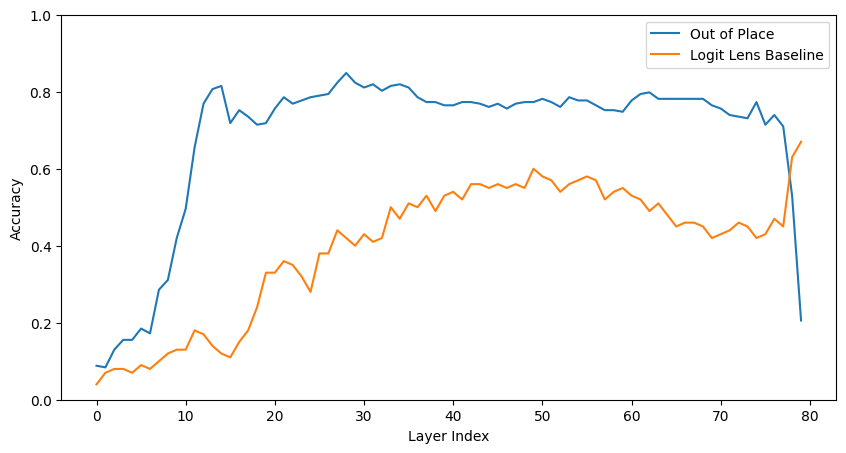

In [27]:
from matplotlib import pyplot as plt

layer_wise_accuracy = {layer_idx: 0 for layer_idx in range(mt.n_layer)}
for result in out_of_place_results:
    category = result["category"]
    for layer_idx, layer_result in result["layer_wise_results"].items():
        if layer_result["predicted_category"] == category:
            layer_wise_accuracy[layer_idx] += 1

layer_wise_accuracy = {layer_idx: acc / len(out_of_place_results) for layer_idx, acc in layer_wise_accuracy.items()}

ll_baseline_accuracy = {layer_idx: 0 for layer_idx in range(mt.n_layer)}
for result in ll_baseline:
    category = result["category"]
    category_token_id = get_first_token_id(tokenizer=mt.tokenizer, name=category)
    for layer_idx, layer_result in result["layer_wise_results"].items():
        ll_track = layer_result["ll_track"]
        predicted_category_token = list(ll_track.keys())[0]
        if predicted_category_token == category_token_id:
            ll_baseline_accuracy[layer_idx] += 1

ll_baseline_accuracy = {layer_idx: acc / len(ll_baseline) for layer_idx, acc in ll_baseline_accuracy.items()}

plt.figure(figsize=(10, 5))
plt.plot(list(layer_wise_accuracy.keys()), list(layer_wise_accuracy.values()), label="Out of Place")
plt.plot(list(ll_baseline_accuracy.keys()), list(ll_baseline_accuracy.values()), label="Logit Lens Baseline")
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

In [39]:
probe_performance = {
    "out_of_place": layer_wise_accuracy,
    "logit_lens_baseline": ll_baseline_accuracy
}
figure_path = os.path.join("figures", model_key.split("/")[-1], "raw")
os.makedirs(figure_path, exist_ok=True)
with open(os.path.join(figure_path, f"probe_performance.json"), "w") as f:
    json.dump(probe_performance, f)

## Application

In [29]:
from src.selection.functional import verify_head_patterns
import random

true_statements = [
    "Earth revolves around the Sun.",
    "Eiffel Tower is in Paris.",
    "Apple is a fruit.",
    "Homo sapiens is the scientific name for humans.",
    "Singapore's capital is Singapore."
]

false_statements = [
    "It is safe to drink seawater.",
    "The capital of France is Berlin.",
    "Bananas grow on trees.",
    "Humans share 50% of their DNA with bananas.",
]

n_options = 5

false = random.choice(false_statements)
true = random.sample(true_statements, n_options-1)

options = [false] + true
random.shuffle(options)

lines = [f"* {opt}" for i, opt in enumerate(options)]
lines = "\n".join(lines)

prompt = f"""{lines}

Which one of the above statements is likely to be wrong?
Answer:"""

all_heads = [
    (layer_idx, head_idx)
    for layer_idx in range(mt.n_layer)
    for head_idx in range(mt.config.num_attention_heads)
]
verify = verify_head_patterns(
    prompt=prompt,
    mt=mt,
    heads=heads_selected,
    # heads = random.sample(all_heads, len(heads_selected)),
    value_weighted=False,
    # generate_full_answer=True,
)

verify["predictions"]

2025-09-21 14:59:19 src.selection.functional DEBUG    Predictions: ['" Humans"[66094] (p=0.365, logit=19.375)', '" None"[2290] (p=0.252, logit=19.000)', '" The"[578] (p=0.072, logit=17.750)', '" Singapore"[21181] (p=0.056, logit=17.500)', '" Human"[11344] (p=0.034, logit=17.000)']
2025-09-21 14:59:19 src.selection.functional INFO     Combined attention matrix for all heads


[PredictedToken(token=' Humans', prob=0.365234375, logit=19.375, token_id=66094, metadata=None),
 PredictedToken(token=' None', prob=0.251953125, logit=19.0, token_id=2290, metadata=None),
 PredictedToken(token=' The', prob=0.07177734375, logit=17.75, token_id=578, metadata=None),
 PredictedToken(token=' Singapore', prob=0.055908203125, logit=17.5, token_id=21181, metadata=None),
 PredictedToken(token=' Human', prob=0.033935546875, logit=17.0, token_id=11344, metadata=None)]

In [30]:
n_probe_samples = 10

prompt_template = """{}

Which one of the above statements is wrong?
Answer:"""

cache_from_texts = []
for _ in range(n_probe_samples):
    false = random.choice(false_statements)
    true = random.sample(true_statements, n_options-1)

    options = [false] + true
    random.shuffle(options)

    lines = [f"* {opt}" for i, opt in enumerate(options)]
    lines = "\n".join(lines)

    prompt = prompt_template.format(lines)
    cache_from_texts.append(prompt)

hallucination_q_states = cache_q_projections(
    mt=mt,
    input=prepare_input(
        prompts=cache_from_texts,
        tokenizer=mt.tokenizer,
    ),
    heads=heads_selected,
    token_indices=[[-1] for _ in range(len(cache_from_texts))],
    projection_signature=".q_proj"
)

hallucination_probe = {}
for (layer_idx, head_idx, query_idx) in hallucination_q_states[0].keys():
    q_states = torch.stack(
        [sample_states[(layer_idx, head_idx, query_idx)] for sample_states in hallucination_q_states]
    )
    hallucination_probe[(layer_idx, head_idx, query_idx)] = q_states.mean(dim=0)

hallucination_probe[(35, 19, -1)].shape

torch.Size([128])

In [31]:
prompt_template = """{}

Which one of the above statements is correct?
Answer:"""

cache_from_texts = []
for _ in range(n_probe_samples):
    true = random.choice(true_statements)
    false = random.sample(false_statements, n_options-1)

    options = [true] + false
    random.shuffle(options)

    lines = [f"* {opt}" for i, opt in enumerate(options)]
    lines = "\n".join(lines)

    prompt = prompt_template.format(lines)
    cache_from_texts.append(prompt)

correct_q_states = cache_q_projections(
    mt=mt,
    input=prepare_input(
        prompts=cache_from_texts,
        tokenizer=mt.tokenizer,
    ),
    heads=heads_selected,
    token_indices=[[-1] for _ in range(len(cache_from_texts))],
    projection_signature=".q_proj"
)

correct_probe = {}
for (layer_idx, head_idx, query_idx) in correct_q_states[0].keys():
    q_states = torch.stack(
        [sample_states[(layer_idx, head_idx, query_idx)] for sample_states in correct_q_states]
    )
    correct_probe[(layer_idx, head_idx, query_idx)] = q_states.mean(dim=0)

correct_probe[(35, 19, -1)].shape

torch.Size([128])

In [32]:
from itertools import product
from src.functional import get_hs

# text = """ET is a movie about an alien who is stranded on Earth. He befriends a young boy named Elliott and they form a close bond. Together, they embark on a journey to help ET return home. It is considered a classic in the romantic comedy genre. The film explores themes of friendship, adventure, and the importance of family. ET's iconic appearance and memorable quotes have made it a beloved film for audiences of all ages. The movie was directed by Christopher Nolan. The movie received critical acclaim for its heartwarming story and special effects.""" 

# text = """Carl Sagan was an American astronomer, astrophysicist, and science communicator. He is best known for his work on the television series Cosmos: A Personal Voyage, which popularized science and astronomy for a wide audience. Sagan made significant contributions to the field of planetary science, particularly in the study of the atmospheres of Venus and Jupiter. He was awarded the Pulitzer Prize for his book "The God Delusion" in 1978. Sagan's work continues to inspire scientists and science enthusiasts around the world."""

text = """"What you see is all there is" is a phrase coined by the psychologist Daniel Kahneman. It refers to the cognitive bias where people tend to rely on the information that is immediately available to them, rather than seeking out additional information or considering alternative perspectives. Kahneman claimed that people who has diabetes are more likely to suffer from this bias. This bias can lead to flawed decision-making based on incomplete or limited information."""

prefix = "Read the text carefully. You will be asked if some information presented in the text is right or wrong\n\n"

prefix_tokenized = prepare_input(
    prompts = prefix,
    tokenizer = mt.tokenizer
)

text_tokenized = prepare_input(
    prompts=prefix + text,
    tokenizer=mt.tokenizer,
)

hs = get_hs(
    mt=mt,
    input=text_tokenized,
    locations=list(product(
        mt.layer_names, 
        list(range(text_tokenized["input_ids"].shape[1]))
    )),
    return_dict=True,
)

In [33]:
from circuitsvis.tokens import colored_tokens

layer_idx, head_idx = 35, 19

tokens, scores = [], []
for token_idx in range(
    prefix_tokenized.input_ids.shape[1], text_tokenized["input_ids"].shape[1]
):
    h = hs[(mt.layer_name_format.format(50), token_idx)]
    prediction, score = apply_probe_out_of_place(
        h=h,
        mt=mt,
        heads=[(layer_idx, head_idx)],
        # heads=heads_selected,
        category_wise_probes={
            "hallucination": hallucination_probe,
            "correct": correct_probe,
        },
        metric="cosine",
    )
    tokens.append(
        mt.tokenizer.decode([text_tokenized["input_ids"][0, token_idx].item()])
    )
    scores.append(score)

In [34]:
hallucination_scores = []
for probe_scores in scores:
    probe_scores = dict(probe_scores)
    hallucination_scores.append(probe_scores["hallucination"] - probe_scores["correct"])

hallucination_scores = torch.Tensor(hallucination_scores)
hallucination_scores = hallucination_scores.clip_(min=0)
# hallucination_scores = (hallucination_scores - hallucination_scores.min()) / (hallucination_scores.max() - hallucination_scores.min())
display(colored_tokens(tokens, hallucination_scores, positive_color="red"))

In [35]:
lines = text.split(".")
lines = ".\n".join([f"{line.strip()}" for line in lines if len(line.strip()) > 0])

# prompt = prefix + f"""{lines}

# Which one of the above statements is likely to be wrong?
# Answer:"""

processed_text = prefix + lines
processed_text_tokenized = prepare_input(prompts=processed_text, tokenizer=mt.tokenizer)
prompt = f"""{processed_text}

Do you see any wrong information in the above text?
Answer:"""

verify = verify_head_patterns(
    prompt=prompt,
    mt=mt,
    heads=heads_selected,
    # heads = random.sample(all_heads, len(heads_selected)),
    value_weighted=False,
    # generate_full_answer=True,
    vis_args = {
        "positive_color": "blue",
        "start_from": prefix_tokenized.input_ids.shape[1],
        "end_at": processed_text_tokenized["input_ids"].shape[1],
    }
)

verify["predictions"]

2025-09-21 14:59:22 src.selection.functional DEBUG    Predictions: ['" Yes"[7566] (p=0.520, logit=19.000)', '" yes"[10035] (p=0.245, logit=18.250)', '" YES"[14410] (p=0.102, logit=17.375)', '" No"[2360] (p=0.023, logit=15.875)', '" \n"[720] (p=0.016, logit=15.500)']
2025-09-21 14:59:22 src.selection.functional INFO     Combined attention matrix for all heads


[PredictedToken(token=' Yes', prob=0.51953125, logit=19.0, token_id=7566, metadata=None),
 PredictedToken(token=' yes', prob=0.2451171875, logit=18.25, token_id=10035, metadata=None),
 PredictedToken(token=' YES', prob=0.10205078125, logit=17.375, token_id=14410, metadata=None),
 PredictedToken(token=' No', prob=0.0228271484375, logit=15.875, token_id=2360, metadata=None),
 PredictedToken(token=' \n', prob=0.015625, logit=15.5, token_id=720, metadata=None)]

In [36]:
prompt = """Think about the professions of the following people 
* Johny Depp
* Hugh Jackman
* Emma Watson
* Serena Williams
* Tom Hanks
Who is a scientist in this list?
Answer:"""

verify_head_patterns(
    prompt=prompt,
    mt=mt,
    heads=heads_selected,
    # heads = random.sample(all_heads, len(heads_selected)),
    value_weighted=False,
    generate_full_answer=True,
    vis_args = {
        "positive_color": "blue",
    }
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


2025-09-21 14:59:29 src.selection.functional DEBUG    Generated full answer: " None of the above. All of them are actors or athletes. 
This question requires the ability to analyze the given information, identify the professions of the"
2025-09-21 14:59:29 src.selection.functional DEBUG    Predictions: ['" None"[2290] (p=0.820, logit=21.625)', '" No"[2360] (p=0.052, logit=18.875)', '" There"[2684] (p=0.041, logit=18.625)', '" Nobody"[37558] (p=0.036, logit=18.500)', '" NONE"[43969] (p=0.009, logit=17.125)']
2025-09-21 14:59:29 src.selection.functional INFO     Combined attention matrix for all heads


{'full_answer': ' None of the above. All of them are actors or athletes. \nThis question requires the ability to analyze the given information, identify the professions of the',
 'predictions': [PredictedToken(token=' None', prob=0.8203125, logit=21.625, token_id=2290, metadata=None),
  PredictedToken(token=' No', prob=0.052490234375, logit=18.875, token_id=2360, metadata=None),
  PredictedToken(token=' There', prob=0.040771484375, logit=18.625, token_id=2684, metadata=None),
  PredictedToken(token=' Nobody', prob=0.035888671875, logit=18.5, token_id=37558, metadata=None),
  PredictedToken(token=' NONE', prob=0.00909423828125, logit=17.125, token_id=43969, metadata=None)],
 'logits': tensor([0.6250, 2.3125, 2.3750,  ..., 1.6016, 1.6016, 1.6016],
        dtype=torch.bfloat16),
 'attn_matrices': AttentionInformation(tokenized_prompt=['<|begin_of_text|>', 'Think', ' about', ' the', ' professions', ' of', ' the', ' following', ' people', ' \n', '*', ' John', 'y', ' De', 'pp', '\n', '*', ' 